# Demo ARIMA Time Series Forecasting on Ray local

In [13]:
# install open-source ray if you haven't already
# !pip install "ray[default] installs the latest version; otherwise use a specific version
# !pip install "ray[default]==1.8.0"

In [14]:
###########
# Import libraries
###########

# Open-source libraries
import time               # Python time functions
import ray                # Run distributed code
import numpy as np        # Numerical processing
import pandas as pd       # Dataframe (tabular data) processing
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Open-source ARIMA forecasting libraries
import warnings
warnings.filterwarnings('ignore')
arima_model_type = "pmdarima.arima.arima.ARIMA"
import pmdarima as pm
from pmdarima.model_selection import train_test_split

!python --version
print(f"ray: {ray.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {mpl.__version__}")
print(f"pmdarima: {pm.__version__}")

Python 3.8.12
ray: 1.8.0
numpy: 1.20.3
pandas: 1.3.4
matplotlib: 3.4.3
pmdarima: 1.8.3


In [15]:
###########
# start-up ray on your laptop for testing purposes
###########

NUM_CPU = 4
# ray.shutdown()  #in case a different ray server is already running

ray.init(
    # prevent errors in case re-running notebook
    ignore_reinit_error=True
    , num_cpus = NUM_CPU
)

2021-11-17 19:24:40,448	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


# Read 8 months clean NYC taxi data 
Normally there is a data cleaning/prep step here to convert raw data -> cleaned data.  We'll dig into details of ETL later.  For now, let's just start with cleaned data...

In [16]:
###########
# Read pandas dataframe
###########
# read 8 months of clean, aggregated monthly taxi data
filename = "data/clean_taxi_monthly.parquet"
g_month = pd.read_parquet(filename) 

# rename "time" column, since prophet expects that, arima doesn't care
g_month.reset_index(inplace=True)
g_month.rename(columns={'pickup_monthly':'time'}, inplace=True)

display(g_month.head())

# Train a model per item_id
item_list = list(g_month['pulocationid'].unique())

,time,pulocationid,trip_quantity,pickup_lat,pickup_lon
0,2019-07-31,1,50,40.689514,-74.176788
1,2019-07-31,10,2201,40.678123,-73.791664
2,2019-07-31,100,138614,40.753513,-73.988785
3,2019-07-31,101,63,40.743721,-73.709068
4,2019-07-31,102,97,40.702679,-73.881996


In [17]:
###########
# Assume these are already-existing functions.
###########

###########
# Define a train_model function, default train on 6 months, inference 2
###########
def train_model_ARIMA(theDF:pd.DataFrame, item_col:str
                , item_value:str, target_col:str
                , train_size:int=6) -> list:
    
    import warnings
    warnings.filterwarnings('ignore')

    # split data into train/test
    train, test = train_test_split(theDF.loc[(theDF[item_col]==item_value), :], train_size=train_size)
    
    # train and fit auto.arima model
    model = pm.auto_arima(y=train[target_col]
                          ,X=train.loc[:, (train.columns!=target_col) 
                                          & (train.columns!=item_col)]
                         )
    
    return [train, test, model]


###########
# Define inference_model function
###########
def inference_model_ARIMA(model:"pmdarima.arima.arima.ARIMA", test:pd.DataFrame
                    , item_col:str, target_col:str) -> pd.DataFrame:
    
    # inference on test data
    forecast = pd.DataFrame(model.predict(n_periods=test.shape[0]
                         , X=test.loc[:, (test.columns!=target_col) & (test.columns!=item_col)]
                         , index=test.index))
    
    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.columns = ['predicted_value']
    forecast.predicted_value = forecast.predicted_value.astype(np.int32)
    forecast = pd.concat([forecast
                         , test.loc[:, target_col].reset_index()]
                         , axis=1)
    forecast.set_index('time', inplace=True)

    return forecast

In [18]:
#%%timeit
###########
# Main Regular Python program flow to train and inference ARIMA models
###########

model = []
train = []
test = []

# Train every model
start = time.time()
train, test, model = map(list, zip(*([train_model_ARIMA(g_month.set_index('time')
                          , item_col='pulocationid'
                          , item_value=v
                          , target_col='trip_quantity'
                          , train_size=6) for p,v in enumerate(item_list)]
                          )))

# Inference every model
forecast = [inference_model_ARIMA(model[p]
                        , test[p]
                        , item_col='pulocationid'
                        , target_col='trip_quantity') 
                     for p in range(len(item_list))]

print(f"Done! Training and forecasting on Regular Python finished in {time.time()-start} seconds")

Done! Training and forecasting on Regular Python finished in 3.6071090698242188 seconds


len(forecast): 260


,predicted_value,trip_quantity
time,,
2020-01-31,49,34
2020-02-29,49,35


,predicted_value,trip_quantity
time,,
2020-01-31,2003,1689
2020-02-29,2003,1386


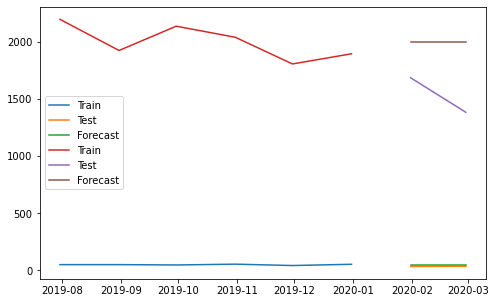

In [19]:
###########
# inspect a few forecasts
###########

assert len(model) == len(item_list)
assert len(forecast) == len(item_list)
print(f"len(forecast): {len(forecast)}")

# eyeball first two forecasts
plt.figure(figsize=(8,5))
for p,v in enumerate(item_list[0:2]):
    display(forecast[p])
    plt.plot(train[p]['trip_quantity'], label="Train")
    plt.plot(test[p]['trip_quantity'], label="Test")
    plt.plot(forecast[p]["predicted_value"], label="Forecast")
    plt.legend(loc='best')

In [20]:
###########
# Convert existing functions to Ray parallelized functions
###########

###########
# Define a train_model function, default train on 6 months, inference 2
###########
@ray.remote(num_returns=3)
def train_model_ARIMA_remote(theDF:pd.DataFrame, item_col:str
                , item_value:str, target_col:str
                , train_size:int=6) -> list:
    
    import warnings
    warnings.filterwarnings('ignore')

    # split data into train/test
    train, test = train_test_split(theDF.loc[(theDF[item_col]==item_value), :], train_size=train_size)
    
    # train and fit auto.arima model
    model = pm.auto_arima(y=train[target_col]
                          ,X=train.loc[:, (train.columns!=target_col) 
                                          & (train.columns!=item_col)]
                         )
    
    # here is the extra pickle step only required for statsmodels objects
    # Explanation why https://alkaline-ml.com/pmdarima/1.0.0/serialization.html
    # return [train, test, model]
    return [train, test, pickle.dumps(model)]


###########
# Define inference_model function
###########
@ray.remote
def inference_model_ARIMA_remote(model_pickle:bytes, test:pd.DataFrame
                    , item_col:str, target_col:str) -> pd.DataFrame:

    # Here is extra unpickle step
    model = pickle.loads(model_pickle)
    
    # inference on test data
    forecast = pd.DataFrame(model.predict(n_periods=test.shape[0]
                         , X=test.loc[:, (test.columns!=target_col) & (test.columns!=item_col)]
                         , index=test.index))
    
    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.columns = ['predicted_value']
    forecast.predicted_value = forecast.predicted_value.astype(np.int32)
    forecast = pd.concat([forecast
                         , test.loc[:, target_col].reset_index()]
                         , axis=1)
    forecast.set_index('time', inplace=True)
    
    return forecast

In [21]:
#%%timeit
###########
# Main Ray distributed program flow to train and inference ARIMA models
###########

model = []
train = []
test = []

# Train every model
start = time.time()
train, test, model = map(list, zip(*([train_model_ARIMA_remote.remote(g_month.set_index('time')
                          , item_col='pulocationid'
                          , item_value=v
                          , target_col='trip_quantity'
                          , train_size=6) for p,v in enumerate(item_list)]
                          )))

# Inference every model
forecast_obj_refs = [inference_model_ARIMA_remote.remote(model[p]
                        , test[p]
                        , item_col='pulocationid'
                        , target_col='trip_quantity') 
                     for p in range(len(item_list))]


# ray blocking step, to get the forecasts
# ray.get() means block until all objectIDs requested are available
forecast = ray.get(forecast_obj_refs)
print(f"Done! Training and forecasting on Ray finished in {time.time()-start} seconds")

Done! Training and forecasting on Ray finished in 1.4075267314910889 seconds


len(forecast): 260


,predicted_value,trip_quantity
time,,
2020-01-31,49,34
2020-02-29,49,35


,predicted_value,trip_quantity
time,,
2020-01-31,2003,1689
2020-02-29,2003,1386


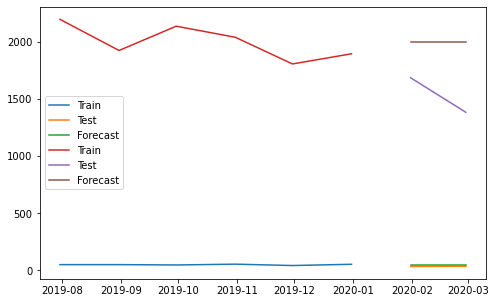

In [22]:
assert len(forecast) == len(item_list)
print(f"len(forecast): {len(forecast)}")
train = ray.get(train)
test = ray.get(test)

# eyeball first two forecasts
plt.figure(figsize=(8,5))
for p in range(len(item_list[0:2])):
    display(forecast[p])
    plt.plot(train[p]['trip_quantity'], label="Train")
    plt.plot(test[p]['trip_quantity'], label="Test")
    plt.plot(forecast[p]["predicted_value"], label="Forecast")
    plt.legend(loc='best')

Forecast for item 1:


,predicted_value,trip_quantity
time,,
2020-01-31,49,34
2020-02-29,49,35


Forecast for item 10:


,predicted_value,trip_quantity
time,,
2020-01-31,2003,1689
2020-02-29,2003,1386


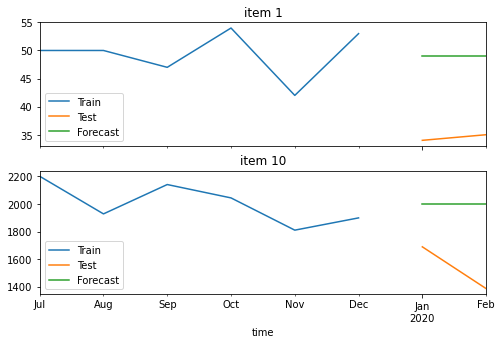

In [23]:
# fancier plots
## inspect your forecasts

# just first two in the list
fig, axs = plt.subplots(2, 1, figsize=(8,5), sharex=True)
for p,v in enumerate(item_list[0:2]):  
    print(f"Forecast for item {v}:")
    display(forecast[p])
    
    ax = axs[p]
    train[p].trip_quantity.plot(ax=ax, label="Train")
    test[p].trip_quantity.plot(ax=ax, label="Test")
    forecast[p].predicted_value.plot(ax=ax, label="Forecast")
    ax.legend(loc='best')
    ax.set_title( f"item {v}" )

In [24]:
###########
# verify intermediate model artifacts, if desired
###########

# ray.get the model artifacts, in case you want to check them
model = ray.get(model)
print(f"len(train): {len(train)}, len(test): {len(test)}, len(model): {len(model)}")


# verify types of objects you got back from ray...
for p in range(len(item_list[0:1])):  #just look at first in the list
    print(f"type(train[{p}]): {type(train[p])}")
    print(f"type(test[{p}]): {type(test[p])}")
    display(train[p])
    display(test[p])
        
    print()
    print(f"type(model[{p}]) before unpickling: {type(model[p])}")
    model[p] = pickle.loads(model[p])
    print(f"type(model[{p}]) after unpickling: {type(model[p])}")
    display(model[p])

len(train): 260, len(test): 260, len(model): 260
type(train[0]): <class 'pandas.core.frame.DataFrame'>
type(test[0]): <class 'pandas.core.frame.DataFrame'>


,pulocationid,trip_quantity,pickup_lat,pickup_lon
time,,,,
2019-07-31,1,50,40.689514,-74.176788
2019-08-31,1,50,40.689514,-74.176788
2019-09-30,1,47,40.689514,-74.176788
2019-10-31,1,54,40.689514,-74.176788
2019-11-30,1,42,40.689514,-74.176788
2019-12-31,1,53,40.689514,-74.176788


,pulocationid,trip_quantity,pickup_lat,pickup_lon
time,,,,
2020-01-31,1,34,40.689514,-74.176788
2020-02-29,1,35,40.689514,-74.176788



type(model[0]) before unpickling: <class 'bytes'>
type(model[0]) after unpickling: <class 'pmdarima.arima.arima.ARIMA'>


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)